In [21]:
%matplotlib inline

# Main libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import timeit

# Work with sql
import psycopg2 
from sqlalchemy import create_engine, text, inspect
from sqlalchemy.engine import URL

In [2]:
# Set folder for files
folder = 'bench_files'
sql_folder = ''

# Establish URL for connection to the database 
url_object = URL.create(
    'postgresql+psycopg2',
    username='postgres',
    password='Ee123456!',
    host='localhost',
    database='Masters:Programing_with_python',
)
engine = create_engine(url_object)

# Set plt style
plt.style.use('ggplot')

# Creating dataset

In [68]:
class SynthDF(pd.DataFrame):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    @property
    def _constructor(self):
        return SynthDF
    
    @classmethod
    def create_data(cls, size):
        """
        Create a synthetic DataFrame with random data.

        Parameters
        ----------
        size : int
            Number of rows in the DataFrame.
        """
        df = cls()
        
        # dates
        dates = pd.date_range('2024-01-01', '2024-12-31')
        df['date'] = np.random.choice(dates, size)
        # int data
        df['tournament_id'] = np.arange(size)
        df['team_id'] = np.random.randint(1, 1000, size)
        df['members'] = np.random.randint(1, 10, size)
        # categorical data
        df['location'] = np.random.choice(['Asia', 'Europe', 'Africa', 'America', 'Oceania'], size)
        df['importance'] = np.random.choice(['local', 'minor', 'major'], size)

        # float data
        df['avg_age'] = np.random.randint(100, 500, size) / 10
        df['prize'] = np.random.randint(10000, 10000000, size) / 100
        df['prob'] = np.random.uniform(0, 1, size)
        # bool data
        df['win'] = np.random.choice([True, False], size)
        
        return df

    def dtypes_setter(self):
        """
        Set data types for columns in a synthetic DataFrame.

        - Integers: 'tournament_id' ('int32'), 'team_id' ('int16'), 'members' ('int8').
        - Categorical: 'location', 'importance'.
        - Floats: 'avg_age' ('float16'), 'prize' ('float32'), 'prob' ('float32').
        """

        # int data
        self['tournament_id'] = self['tournament_id'].astype('int32')
        self['team_id'] = self['team_id'].astype('int16')
        self['members'] = self['members'].astype('int8')

        # categorical data
        self['location'] = self['location'].astype('category')
        self['importance'] = self['importance'].astype('category')

        # float data
        self['avg_age'] = self['avg_age'] .astype('float32')
        self['prize'] = self['prize'].astype('float32')
        self['prob'] = self['prob'].astype('float32')

    def benchmark(self, f_name, write_method, read_method, kwargs_write={}, kwargs_read={}):
        """
        Benchmark the performance and space requirements of writing and reading a DataFrame.

        Parameters
        ----------
        f_name : str
            The name of the file to be used for benchmarking.
        write_method : callable
            The method used to write the DataFrame to a file.
        read_method : callable
            The method used to read the DataFrame from a file.
        kwargs_write : dict, optional
            Additional keyword arguments for the write method.
        kwargs_read : dict, optional
            Additional keyword arguments for the read method.

        Returns
        -------
        dict
            A dictionary containing benchmark results.
            - 'format': The file format extension.
            - 'df_size': The size identifier of the DataFrame.
            - 'write': Timing information for the write operation.
            - 'read': Timing information for the read operation.
            - 'size': The size of the file on disk in bytes.
            - 'metadata': Whether metadata (data types) is preserved in the read operation.
        """
        # Set path to file 
        file = os.path.join(folder, f_name)

        # Bench write time
        write = %timeit -o write_method(self, file, **kwargs_write)

        # Bench read time
        read = %timeit -o read_method(file, **kwargs_read)

        # Bench size of file
        if write_method == pd.DataFrame.to_sql:
            # Get size of SQL db
            with engine.connect() as conn:
                query = text(f"SELECT pg_total_relation_size('{f_name}')")
                space = conn.execute(query).scalar()
                f_name += '.sql'
        else:
            # Get size of file 
            space = os.path.getsize(file)
        print(f'{space} bytes (required space)')

        # Metadata
        new_df = read_method(file, **kwargs_read)
        ziped = zip(new_df.dtypes, self.dtypes) 
        saved_metadata = [type1.base == type2.base for type1, type2 in ziped]
        print('metadata is saved' if all(saved_metadata) else 'metadata is NOT saved')

        result = {
            'format': f_name.split('.')[-1],
            'df_size': f_name.split('_')[0],
            'write': write.average,
            'read': read.average,
            'size': space,
            'metadata': all(saved_metadata)
        }

        return result

In [69]:
# Data synthesis
df_small = SynthDF.create_data(10000)
df_medium = SynthDF.create_data(100000)
df_large = SynthDF.create_data(1000000)

# Change dtypes
df_small.dtypes_setter()
df_medium.dtypes_setter()
df_large.dtypes_setter()

In [73]:
# Init df for result
result = pd.DataFrame(columns=['format','df_size','write', 'read', 'size', 'metadata'])

# CSV

In [74]:
temp = df_small.benchmark(
    f_name='s_csv.csv', 
    write_method=pd.DataFrame.to_csv, 
    read_method=pd.read_csv,
    kwargs_write={'index': False}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

58.4 ms ± 2.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
13.4 ms ± 387 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
657283 bytes (required space)
metadata is NOT saved


In [75]:
temp = df_medium.benchmark(
    f_name='m_csv.csv', 
    write_method=pd.DataFrame.to_csv, 
    read_method=pd.read_csv,
    kwargs_write={'index': False}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

632 ms ± 50.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
112 ms ± 8.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
6670482 bytes (required space)
metadata is NOT saved


In [76]:
temp = df_large.benchmark(
    f_name='l_csv.csv', 
    write_method=pd.DataFrame.to_csv, 
    read_method=pd.read_csv,
    kwargs_write={'index': False}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

5.44 s ± 136 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
900 ms ± 8.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
67700049 bytes (required space)
metadata is NOT saved


# JSON

In [77]:
temp = df_small.benchmark(
    f_name='s_json.json', 
    write_method=pd.DataFrame.to_json, 
    read_method=pd.read_json,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

13.6 ms ± 123 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
59.4 ms ± 933 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1553701 bytes (required space)
metadata is NOT saved


In [78]:
temp = df_medium.benchmark(
    f_name='m_json.json', 
    write_method=pd.DataFrame.to_json, 
    read_method=pd.read_json,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

131 ms ± 746 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
654 ms ± 19.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
16630095 bytes (required space)
metadata is NOT saved


In [79]:
temp = df_large.benchmark(
    f_name='l_json.json', 
    write_method=pd.DataFrame.to_json, 
    read_method=pd.read_json,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

1.44 s ± 20.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.15 s ± 33.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
177282931 bytes (required space)
metadata is NOT saved


# SQL?

In [80]:
temp = df_small.benchmark(
    f_name='s_sql', # This case sql db name
    write_method=pd.DataFrame.to_sql, 
    read_method=pd.read_sql_table,
    kwargs_write={'con':engine, 'if_exists':'replace', 'index':False},
    kwargs_read={'con':engine}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

509 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
78.2 ms ± 859 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
811008 bytes (required space)
metadata is NOT saved


# Pickle

In [81]:
temp = df_small.benchmark(
    f_name='s_pickle.pickle', 
    write_method=pd.DataFrame.to_pickle, 
    read_method=pd.read_pickle,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

763 µs ± 5.25 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
579 µs ± 7.99 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
301977 bytes (required space)
metadata is saved


In [82]:
temp = df_medium.benchmark(
    f_name='m_pickle.pickle', 
    write_method=pd.DataFrame.to_pickle, 
    read_method=pd.read_pickle,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

1.89 ms ± 44.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.3 ms ± 9.86 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
3002062 bytes (required space)
metadata is saved


In [83]:
temp = df_large.benchmark(
    f_name='l_pickle.pickle', 
    write_method=pd.DataFrame.to_pickle, 
    read_method=pd.read_pickle,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

13.5 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.6 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
30002062 bytes (required space)
metadata is saved


# Feather
`
!pip istall pyarrow
`

In [84]:
temp = df_small.benchmark(
    f_name='s_feather.feather', 
    write_method=pd.DataFrame.to_feather, 
    read_method=pd.read_feather,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

4.53 ms ± 156 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.27 ms ± 53.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
229146 bytes (required space)
metadata is saved


In [85]:
temp = df_medium.benchmark(
    f_name='m_feather.feather', 
    write_method=pd.DataFrame.to_feather, 
    read_method=pd.read_feather,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

7.49 ms ± 73 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.37 ms ± 88.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2189242 bytes (required space)
metadata is saved


In [86]:
temp = df_large.benchmark(
    f_name='l_feather.feather', 
    write_method=pd.DataFrame.to_feather, 
    read_method=pd.read_feather,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

36.7 ms ± 589 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
38.9 ms ± 2.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
21825562 bytes (required space)
metadata is saved


# Parquet
`
!pip istall fastparquet
`

In [87]:
temp = df_small.benchmark(
    f_name='s_parquet.parquet', 
    write_method=pd.DataFrame.to_parquet, 
    read_method=pd.read_parquet,
    kwargs_write={'engine':'fastparquet'},
    kwargs_read={'engine':'fastparquet'}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

9.86 ms ± 542 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.18 ms ± 63.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
235540 bytes (required space)
metadata is saved


In [88]:
temp = df_medium.benchmark(
    f_name='m_parquet.parquet', 
    write_method=pd.DataFrame.to_parquet, 
    read_method=pd.read_parquet,
    kwargs_write={'engine':'fastparquet'},
    kwargs_read={'engine':'fastparquet'}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

20.3 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.65 ms ± 303 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2311556 bytes (required space)
metadata is saved


In [89]:
temp = df_large.benchmark(
    f_name='l_parquet.parquet', 
    write_method=pd.DataFrame.to_parquet, 
    read_method=pd.read_parquet,
    kwargs_write={'engine':'fastparquet'},
    kwargs_read={'engine':'fastparquet'}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

138 ms ± 2.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
65.1 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
23062643 bytes (required space)
metadata is saved


# Show results

In [90]:
result['size'] /= 1_000_000 # Convert to MB
result

,format,df_size,write,read,size,metadata
0,csv,s,0.058356,0.013401,0.657283,False
1,csv,m,0.632408,0.112084,6.670482,False
2,csv,l,5.435706,0.900079,67.700049,False
3,json,s,0.013569,0.059357,1.553701,False
4,json,m,0.130575,0.653563,16.630095,False
5,json,l,1.442994,9.154271,177.282931,False
6,sql,s,0.508832,0.078224,0.811008,False
7,pickle,s,0.000763,0.000579,0.301977,True
8,pickle,m,0.001891,0.0013,3.002062,True
9,pickle,l,0.013516,0.013577,30.002062,True


# Group data

In [91]:
# Group DF by 'format' and 'df_size'
grouped = result.groupby(['format', 'df_size']).mean().unstack()
grouped

write                          read                      \
df_size         l         m         s         l         m         s   
format                                                                
csv      5.435706  0.632408  0.058356  0.900079  0.112084  0.013401   
feather  0.036657  0.007487  0.004529  0.038891   0.00637  0.003271   
json     1.442994  0.130575  0.013569  9.154271  0.653563  0.059357   
parquet  0.137526   0.02027  0.009857  0.065055  0.008651  0.004183   
pickle   0.013516  0.001891  0.000763  0.013577    0.0013  0.000579   
sql           NaN       NaN  0.508832       NaN       NaN  0.078224   

               size                      metadata            
df_size           l          m         s        l    m    s  
format                                                       
csv       67.700049   6.670482  0.657283      0.0  0.0  0.0  
feather   21.825562   2.189242  0.229146      1.0  1.0  1.0  
json     177.282931  16.630095  1.553701      0.0  0.0  0.0  
parquet   23.062643   2.311556   0.23554      1.0  1.0  1.0  
pickle    30.002062   3.002062  0.301977      1.0  1.0  1.0  
sql             NaN        NaN  0.811008      NaN  NaN  0.0

In [92]:
binary = grouped.query('format not in ["csv", "json"]')
binary

write                          read                      \
df_size         l         m         s         l         m         s   
format                                                                
feather  0.036657  0.007487  0.004529  0.038891   0.00637  0.003271   
parquet  0.137526   0.02027  0.009857  0.065055  0.008651  0.004183   
pickle   0.013516  0.001891  0.000763  0.013577    0.0013  0.000579   
sql           NaN       NaN  0.508832       NaN       NaN  0.078224   

              size                     metadata            
df_size          l         m         s        l    m    s  
format                                                     
feather  21.825562  2.189242  0.229146      1.0  1.0  1.0  
parquet  23.062643  2.311556   0.23554      1.0  1.0  1.0  
pickle   30.002062  3.002062  0.301977      1.0  1.0  1.0  
sql            NaN       NaN  0.811008      NaN  NaN  0.0

# Draw graphs

In [93]:
def plot_data(df, title='', y_label=''):
    ax = df.plot(kind='bar', figsize=(12, 6), width=0.8, logy=True)
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 4)), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', 
                    va='center', 
                    xytext=(0, 30), 
                    textcoords='offset points',
                    rotation=90
                   )

    plt.title(title)
    plt.xlabel('File format')
    plt.xticks(rotation=0)
    plt.ylabel(y_label)
    plt.ylim(top=df.max().max()*10)

## read

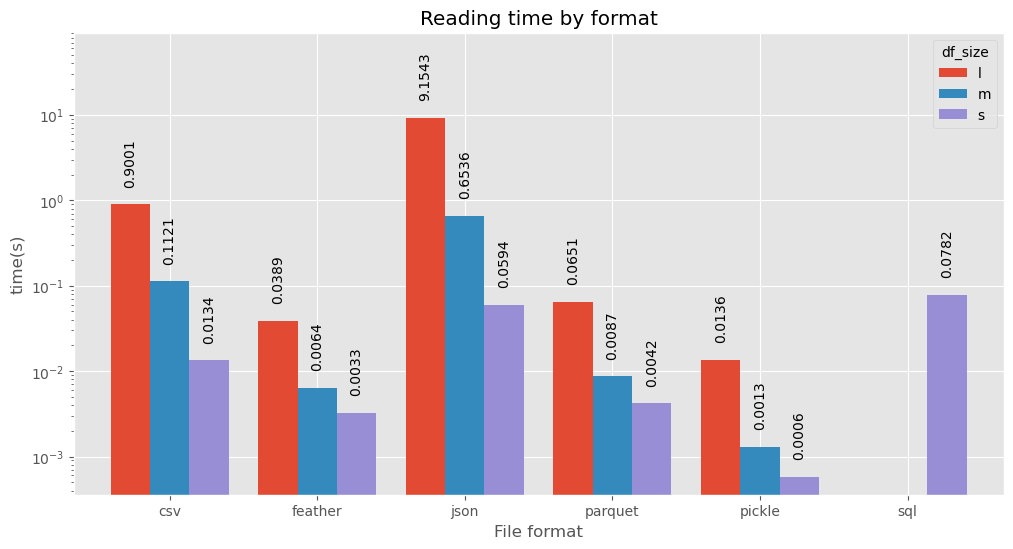

In [94]:
plot_data(grouped['read'], 'Reading time by format', 'time(s)')

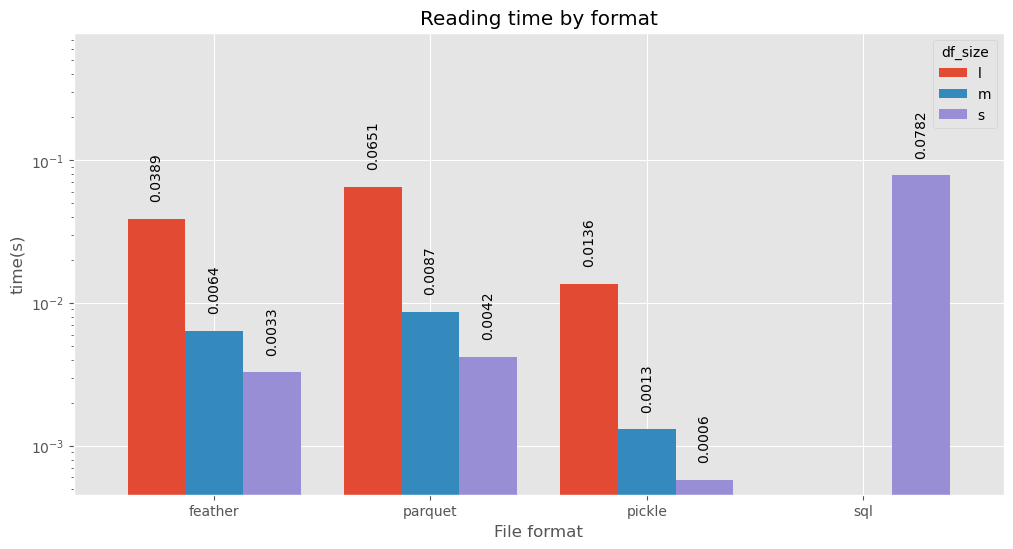

In [95]:
plot_data(binary['read'], 'Reading time by format', 'time(s)')

## write

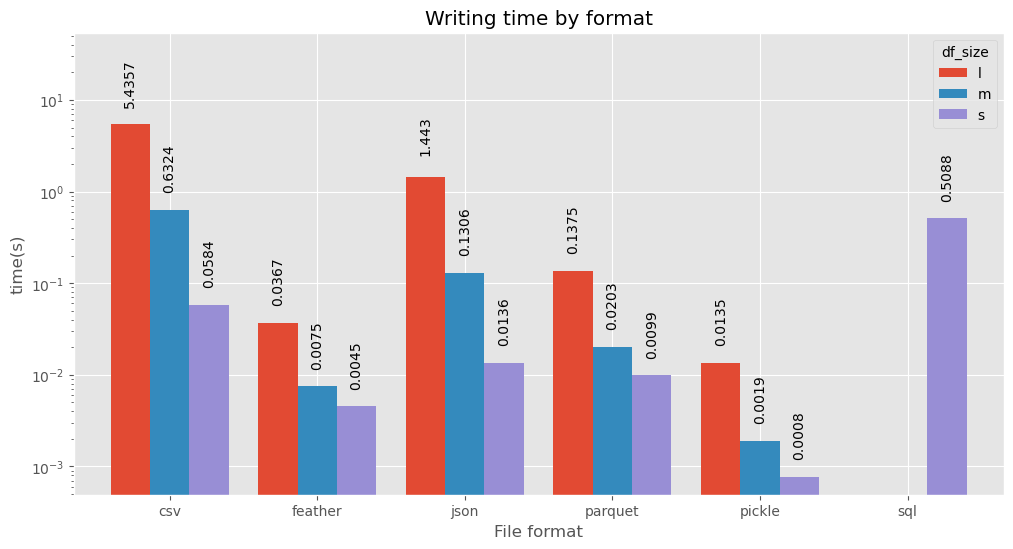

In [96]:
plot_data(grouped['write'], 'Writing time by format', 'time(s)')

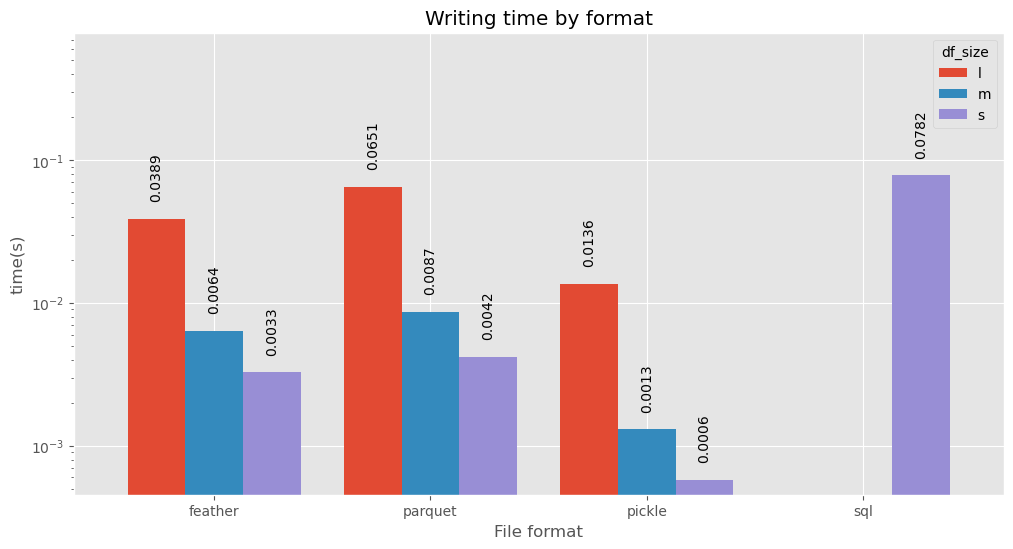

In [97]:
plot_data(binary['read'], 'Writing time by format', 'time(s)')

## size

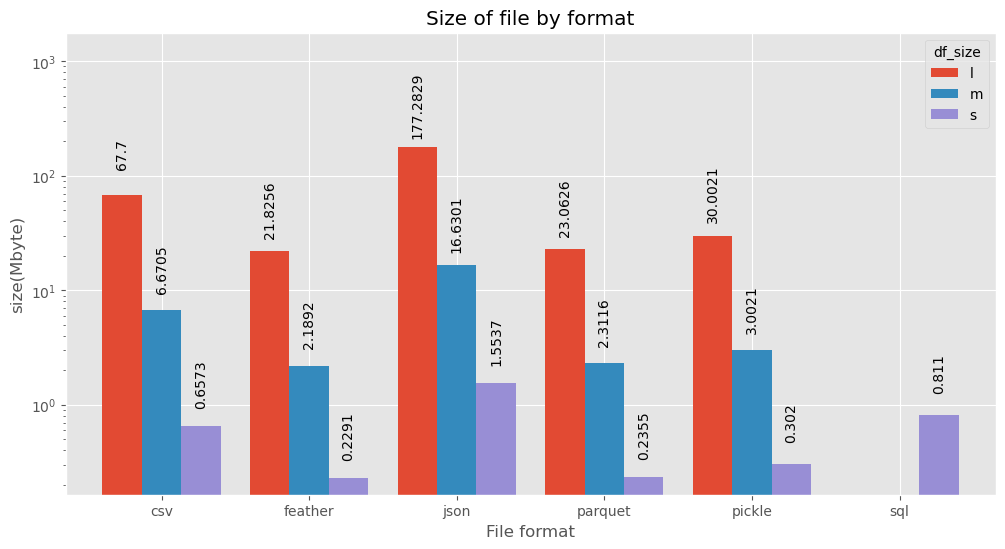

In [98]:
plot_data(grouped['size'], 'Size of file by format', 'size(Mbyte)')